In [ ]:
!wget https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
!unzip individual+household+electric+power+consumption.zip

--2025-06-13 08:37:28--  https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘individual+household+electric+power+consumption.zip’

individual+househol     [    <=>             ]  19.68M  28.1MB/s    in 0.7s    

2025-06-13 08:37:29 (28.1 MB/s) - ‘individual+household+electric+power+consumption.zip’ saved [20640916]

Archive:  individual+household+electric+power+consumption.zip
  inflating: household_power_consumption.txt  


In [ ]:
pip install Groq

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from groq import Groq
import json
import re

In [ ]:
Groq_api_key = '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'
client =Groq(api_key=Groq_api_key)

In [ ]:
#Load and and preprocess the dataset
def load_data_set():
    df = pd.read_csv('household_power_consumption.txt',
             	sep=';',
             	parse_dates={'datetime': ['Date', 'Time']},
             	infer_datetime_format=True,
             	na_values=['?'],
             	low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')
    return df

In [ ]:
# Function to generate pandas code from natural language question using GROQ API

def generate_pandas_code(natural_language_question, model_name, df_info):
    df_info_str = json.dumps(df_info)

    prompt = f"""You are a python expert and you are given a dataset which is preprocessed using below code:

    df = pd.read_csv('household_power_consumption.txt',
                     sep=';',
                     parse_dates={{'datetime': ['Date', 'Time']}},
                     infer_datetime_format=True,
                     na_values=['?'],
                     low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')

    and following are the column names in the dataset after preprocessing where as you can see that the index is set to datetime:
    {df_info_str}


    Provide me with only python pandas code for below natural language questions no theory, explanation is needed. Please only provide the pandas code with necessary imports which should print the result when executed:
    {natural_language_question}

    """

    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model=model_name,
            temperature=0.1,
        )
        return chat_completion.choices[0].message.content

    except Exception as e:
        print(f"GROQ API error: {e}")
        return None

In [ ]:
# Function to execute the generated pandas code and display the output

def execute_query(query,model_name,df):
    df_info = {'columns': df.columns.tolist()}

    code = generate_pandas_code(query,model_name,df_info)
    #print("Python panda code is: \n",code)

    # Clean the code by removing markdown formatting so that it can be executed
    if code:
        code_clean = re.sub(r"```(?:python)?\n?|```", "", code).strip()
        code_clean = re.sub(r"<think>.*?</think>", "", code_clean, flags=re.DOTALL).strip()
        code_clean = code_clean.strip().split('\n')
        valid_lines = []
        for line in code_clean:
            # Include lines that look like real Python code (simple heuristic)
            if line.strip().startswith(("print", "df", "#", "import", "average", "result")) or "=" in line:
                valid_lines.append(line)

        final_code = '\n'.join(valid_lines)
        fixed_code = re.sub(
            r"df\[(df\.index\.\w+\s*==\s*\d+)\]\[(df\.index\.\w+\s*==\s*\d+)\]",
            r"df[(\1) & (\2)]",
            final_code
        )
        print("------------------------------------------------------------------------\nPython pandas Code is:\n\n", fixed_code)

    try:
        print("------------------------------------------------------------------------\nOutput of the code is:\n")
        exec(fixed_code, {'df': df}) #execute the code in the context of the dataframe
    except Exception as e:
        print(f"Error executing code: {e}")
        return False

In [ ]:
df = load_data_set()

<ipython-input-63-2730963339>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt',
<ipython-input-63-2730963339>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt',
<ipython-input-63-2730963339>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt',


In [ ]:
print(df)

                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

           

In [ ]:
print(df.columns.tolist())

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


In [ ]:
#qwen/qwen3-32b model testing

# Consider for Analysis

In [ ]:
execute_query("What was the average active power consumption in March 2007?", "qwen/qwen3-32b", df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')
result = df['2007-03']['Global_active_power'].mean()
print(result)
------------------------------------------------------------------------
Output of the code is:



<string>:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


Error executing code: '2007-03'


False

In [ ]:
execute_query(" Find days where energy consumption exceeded 5 kWh.","qwen/qwen3-32b",df)

------------------------------------------------------------------------
Python pandas Code is:

 ["daily_energy = df['Global_active_power'].resample('D').sum() / 60", 'print(daily_energy[daily_energy > 5].index)']
------------------------------------------------------------------------
Output of the code is:

DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
               '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
               '2010-11-25', '2010-11-26'],
              dtype='datetime64[ns]', name='datetime', length=1409, freq=None)


------------------------------------------------------------------------
Python pandas Code is:

 ["df.loc['2007-01-01':'2007-01-07', 'Global_active_power'].plot()"]
------------------------------------------------------------------------
Output of the code is:



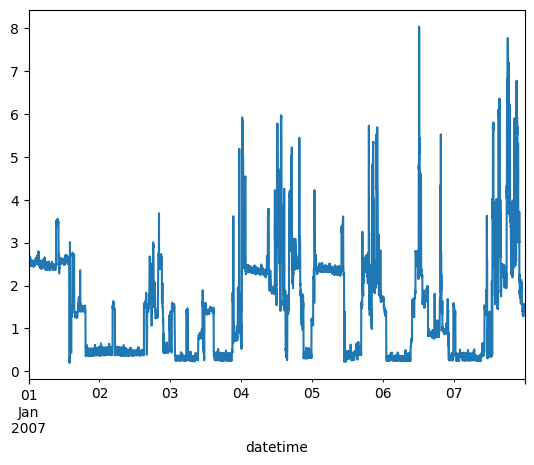

In [ ]:
execute_query("Plot the energy usage trend for the first week of January 2007.","qwen/qwen3-32b",df)

------------------------------------------------------------------------
Python pandas Code is:

 ['import matplotlib.pyplot as plt', '', "# Categorize each timestamp as 'Weekday' or 'Weekend'", "df['DayType'] = df.index.to_series().dt.weekday.apply(lambda x: 'Weekday' if x < 5 else 'Weekend')", '', "# Group by 'DayType' and sum the active power", "grouped = df.groupby('DayType')['Global_active_power'].sum()", '', '# Plot the comparison', "grouped.plot(kind='bar', color=['skyblue', 'salmon'], title='Energy Usage: Weekdays vs Weekends')", "plt.xlabel('Day Type')", "plt.ylabel('Total Global Active Power (kW)')", 'plt.show()']
------------------------------------------------------------------------
Output of the code is:



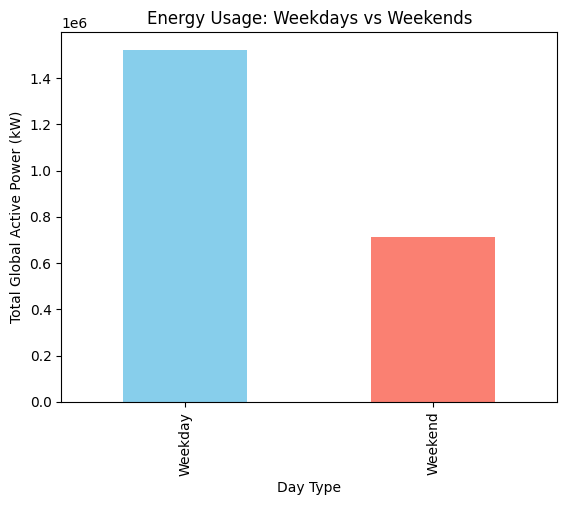

In [ ]:
execute_query("Compare energy usage (Global_active_power) on weekdays vs weekends. Can you show it using visualizatio tool","qwen/qwen3-32b",df)

In [ ]:
execute_query("Find days where average energy consumption exceeded 5 kW.","qwen/qwen3-32b",df)

------------------------------------------------------------------------
Python pandas Code is:

 ["print(df.resample('D')['Global_active_power'].mean().loc[lambda x: x > 5])"]
------------------------------------------------------------------------
Output of the code is:

Series([], Freq: D, Name: Global_active_power, dtype: float64)


In [ ]:
execute_query("Find days where total average energy consumption exceeded 5kWh","qwen/qwen3-32b",df)

------------------------------------------------------------------------
Python pandas Code is:

 ["daily_energy = df['Global_active_power'].resample('D').sum() * (1/60)", 'print(daily_energy[daily_energy > 5])']
------------------------------------------------------------------------
Output of the code is:

datetime
2006-12-16    20.152933
2006-12-17    56.507667
2006-12-18    36.730433
2006-12-19    27.769900
2006-12-20    37.095800
                ...    
2010-11-22    34.025600
2010-11-23    26.292267
2010-11-24    29.937467
2010-11-25    23.852733
2010-11-26    24.801733
Name: Global_active_power, Length: 1409, dtype: float64


------------------------------------------------------------------------
Python pandas Code is:

 ['import matplotlib.pyplot as plt', '', "df.loc['2007-01-01':'2007-01-07', 'Global_active_power'].plot()", "plt.title('Energy Usage Trend - First Week of January 2007')", "plt.xlabel('Date and Time')", "plt.ylabel('Global Active Power (kW)')", 'plt.show()']
------------------------------------------------------------------------
Output of the code is:



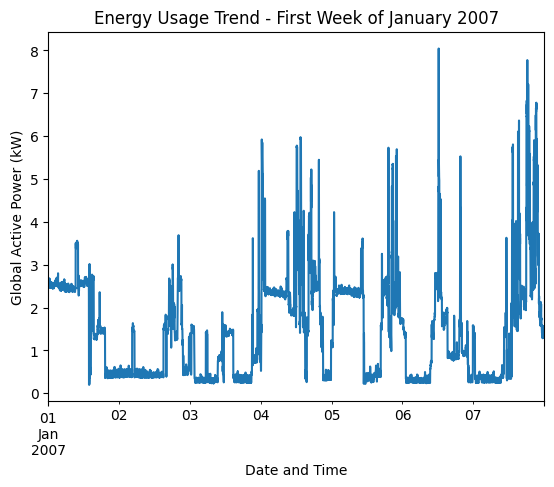

In [ ]:
execute_query("Plot the energy usage trend for the first week of January 2007.","qwen/qwen3-32b",df)

------------------------------------------------------------------------
Python pandas Code is:

 ['import matplotlib.pyplot as plt', '', '# Filter data for the first week of January 2007', "filtered_data = df['2007-01-01':'2007-01-07']", '', '# Aggregate data by day (sum)', "daily_aggregated = filtered_data.resample('D').sum()", '', '# Plot the aggregated Global_active_power', "daily_aggregated['Global_active_power'].plot()", "plt.title('Daily Energy Usage Trend (First Week of January 2007)')", "plt.xlabel('Date')", "plt.ylabel('Global Active Power (kW)')", 'plt.show()']
------------------------------------------------------------------------
Output of the code is:



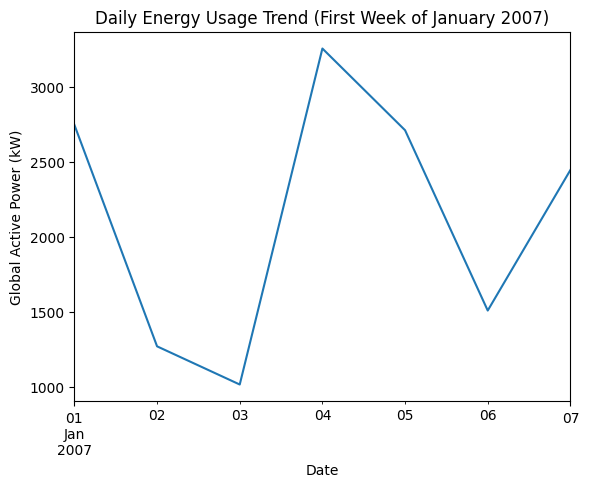

In [ ]:
execute_query("Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day","qwen/qwen3-32b",df)

In [ ]:
execute_query("Find the average voltage for each day of the first week of February 2007","qwen/qwen3-32b",df)

------------------------------------------------------------------------
Python pandas Code is:

 ['Here is the Python pandas code to compute the average voltage for each day of the first week of February 2007:', '', "print(df.loc['2007-02-01':'2007-02-07', 'Voltage'].resample('D').mean())", '', '---', '', '### Explanation:', '', "- `df.loc['2007-02-01':'2007-02-07', 'Voltage']`: Selects the `Voltage` column for all rows with a datetime index between February 1, 2007, and February 7, 2007 (inclusive).", "- `.resample('D')`: Groups the data by day (`D` stands for daily frequency).", '- `.mean()`: Computes the mean of the `Voltage` values for each day.', '- `print(...)`: Outputs the resulting Series, where each index is a date and the value is the average voltage for that day.']
------------------------------------------------------------------------
Output of the code is:

Error executing code: invalid syntax (<string>, line 1)


False

------------------------------------------------------------------------
Python pandas Code is:

 ['import pandas as pd', 'import matplotlib.pyplot as plt', '', '# Compute correlations', "sub_meterings = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']", "columns = ['Global_active_power'] + sub_meterings", "corr_values = df[columns].corr()['Global_active_power'][sub_meterings]", '', 'print("Correlation between Global Active Power and Sub-metering values:")', 'print(corr_values)', '', '# Visualization', 'for sm in sub_meterings:', '    plt.figure(figsize=(10, 6))', "    plt.scatter(df['Global_active_power'], df[sm], alpha=0.5, s=10)", "    plt.title(f'Global Active Power vs {sm} (Correlation: {corr_values[sm]:.2f})')", "    plt.xlabel('Global Active Power')", '    plt.ylabel(sm)', '    plt.grid(True)', '    plt.show()']
------------------------------------------------------------------------
Output of the code is:

Correlation between Global Active Power and Sub-metering values:
S

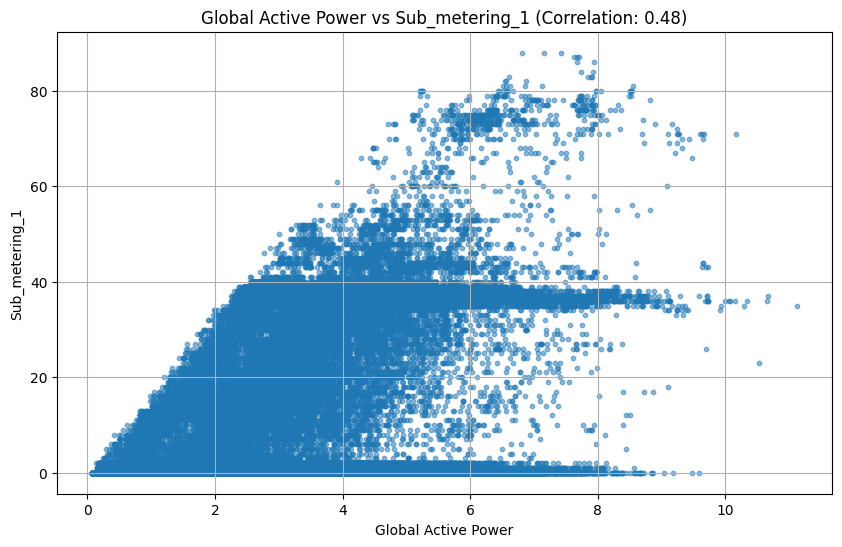

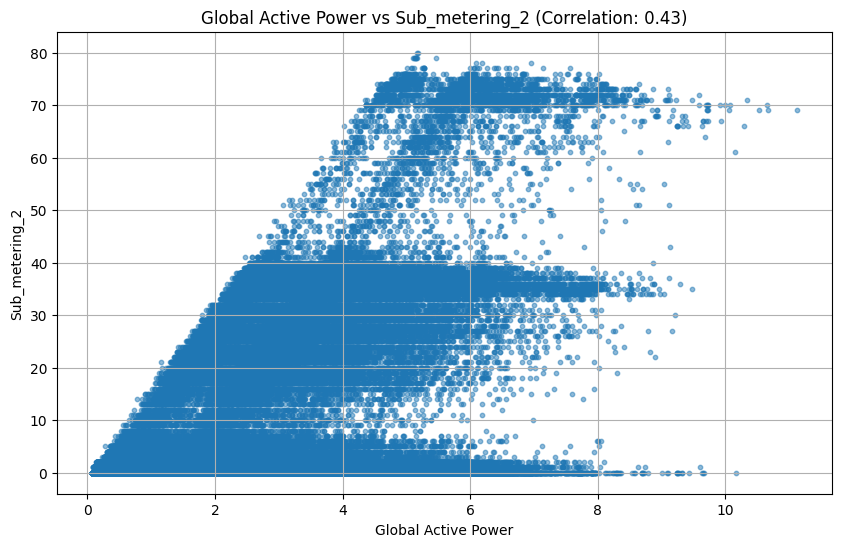

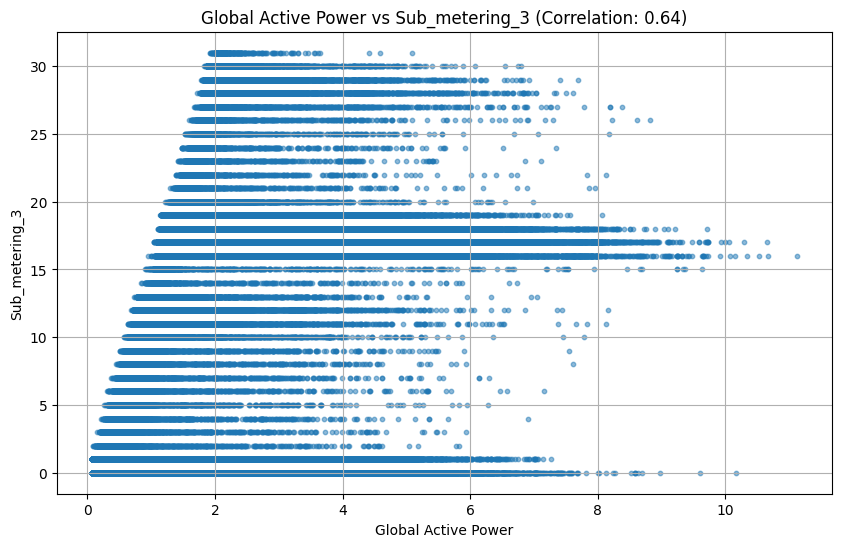

In [ ]:
execute_query("What is the correlation between global active power and sub-metering values?. Can you show it using visualization","qwen/qwen3-32b",df)

In [ ]:
execute_query("Find the average voltage for each day of the first week of February 2008","qwen/qwen3-32b",df)

------------------------------------------------------------------------
Python pandas Code is:

 ["print(df.loc['2008-02-01':'2008-02-07'].resample('D')['Voltage'].mean())"]
------------------------------------------------------------------------
Output of the code is:

datetime
2008-02-01    240.360271
2008-02-02    240.290514
2008-02-03    240.340722
2008-02-04    240.255208
2008-02-05    240.976917
2008-02-06    238.413715
2008-02-07    241.070549
Freq: D, Name: Voltage, dtype: float64


In [ ]:
execute_query("Find days where total energy consumption exceeded 2 kWh in 2008","qwen/qwen3-32b",df)

------------------------------------------------------------------------
Python pandas Code is:

 ["print(df[df.index.year == 2008]['Global_active_power'].resample('D').sum().mul(1/60).loc[lambda x: x > 2].index)"]
------------------------------------------------------------------------
Output of the code is:

DatetimeIndex(['2008-01-01', '2008-01-02', '2008-01-03', '2008-01-04',
               '2008-01-05', '2008-01-06', '2008-01-07', '2008-01-08',
               '2008-01-09', '2008-01-10',
               ...
               '2008-12-22', '2008-12-23', '2008-12-24', '2008-12-25',
               '2008-12-26', '2008-12-27', '2008-12-28', '2008-12-29',
               '2008-12-30', '2008-12-31'],
              dtype='datetime64[ns]', name='datetime', length=366, freq='D')


In [ ]:
execute_query("What hour of the day had the highest power usage on Christmas 2006?","qwen/qwen3-32b",df)

------------------------------------------------------------------------
Python pandas Code is:

 ["christmas_2006 = df.loc['2006-12-25']", "hourly_usage = christmas_2006.groupby(christmas_2006.index.hour)['Global_active_power'].sum()", 'max_hour = hourly_usage.idxmax()', 'print(max_hour)']
------------------------------------------------------------------------
Output of the code is:

22


In [ ]:
print("Loading dataset...")

if df is not None:
  print("Dataset loaded successfully.")

  while True:
      query = input("Enter your natural language question (or type 'exit' to quit): ")
      if query.lower() == 'exit':
          quit()
      execute_query(query, "qwen/qwen3-32b", df)
      print("\nQuery executed successfully.\n------------------------------------------------------------------------\n")
else:
  print("Failed to load dataset. Please check the file path and format.")

Loading dataset...
Dataset loaded successfully.
Enter your natural language question (or type 'exit' to quit): What hour of the day had the highest power usage on Christmas 2008?
------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd

df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)

df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')

christmas_2008 = df.loc['2008-12-25']
hourly_usage = christmas_2008.groupby(christmas_2008.index.hour)['Global_active_power'].sum()
max_hour = hourly_usage.idxmax()
print(max_hour)
------------------------------------------------------------------------
Output of the code is:



<string>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


0

Query executed successfully.
------------------------------------------------------------------------

Enter your natural language question (or type 'exit' to quit): What is the correlation between global active power and sub-metering values?
------------------------------------------------------------------------
Python pandas Code is:

 print(df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr().iloc[0][1:])
------------------------------------------------------------------------
Output of the code is:

Sub_metering_1    0.484401
Sub_metering_2    0.434569
Sub_metering_3    0.638555
Name: Global_active_power, dtype: float64

Query executed successfully.
------------------------------------------------------------------------

Enter your natural language question (or type 'exit' to quit): exit
------------------------------------------------------------------------
Python pandas Code is:

 The user did not provide any specific questions to address

KeyboardInterrupt: Interrupted by user

In [ ]:
!wget https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
!unzip individual+household+electric+power+consumption.zip

--2025-06-13 07:25:36--  https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘individual+household+electric+power+consumption.zip.1’

individual+househol     [  <=>               ]  19.68M  66.2MB/s    in 0.3s    

2025-06-13 07:25:37 (66.2 MB/s) - ‘individual+household+electric+power+consumption.zip.1’ saved [20640916]

Archive:  individual+household+electric+power+consumption.zip
replace household_power_consumption.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: household_power_consumption.txt  


In [ ]:
pip install Groq

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from groq import Groq
import json
import re

In [ ]:
Groq_api_key = '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'
client =Groq(api_key=Groq_api_key)

In [ ]:
#Load and and preprocess the dataset
def load_data_set():
    df = pd.read_csv('household_power_consumption.txt',
             	sep=';',
             	parse_dates={'datetime': ['Date', 'Time']},
             	infer_datetime_format=True,
             	na_values=['?'],
             	low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')
    return df

In [ ]:
# Function to generate pandas code from natural language question using GROQ API

def generate_pandas_code(natural_language_question, model_name, df_info):
    df_info_str = json.dumps(df_info)

    prompt = f"""You are a python expert and you are given a dataset which is preprocessed using below code:

    df = pd.read_csv('household_power_consumption.txt',
                     sep=';',
                     parse_dates={{'datetime': ['Date', 'Time']}},
                     infer_datetime_format=True,
                     na_values=['?'],
                     low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')

    and following are the column names in the dataset after preprocessing where as you can see that the index is set to datetime:
    {df_info_str}


    Provide me with only python pandas code for below natural language questions no theory, explanation is needed. Please only provide the pandas code with necessary imports which should print the result when executed:
    {natural_language_question}

    """

    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model=model_name,
            temperature=0.1,
        )
        return chat_completion.choices[0].message.content

    except Exception as e:
        print(f"GROQ API error: {e}")
        return None

In [ ]:
# Function to execute the generated pandas code and display the output

def execute_query(query,model_name,df):
    df_info = {'columns': df.columns.tolist()}

    code = generate_pandas_code(query,model_name,df_info)
    #print("Python panda code is: \n",code)

    # Clean the code by removing markdown formatting so that it can be executed
    if code:
        code_clean = re.sub(r"```(?:python)?\n?|```", "", code).strip()
        code_clean = re.sub(r"<think>.*?</think>", "", code_clean, flags=re.DOTALL).strip()
        code_clean = code_clean.strip().split('\n')
        valid_lines = []
        for line in code_clean:
            # Include lines that look like real Python code (simple heuristic)
            if line.strip().startswith(("print", "df", "#", "import", "average", "result")) or "=" in line:
                valid_lines.append(line)

        final_code = '\n'.join(valid_lines)
        fixed_code = re.sub(
            r"df\[(df\.index\.\w+\s*==\s*\d+)\]\[(df\.index\.\w+\s*==\s*\d+)\]",
            r"df[(\1) & (\2)]",
            final_code
        )
        print("------------------------------------------------------------------------\nPython pandas Code is:\n\n", fixed_code)

    try:
        print("------------------------------------------------------------------------\nOutput of the code is:\n")
        exec(fixed_code, {'df': df}) #execute the code in the context of the dataframe
    except Exception as e:
        print(f"Error executing code: {e}")
        return False

In [ ]:
df = load_data_set()

<ipython-input-63-2730963339>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt',
<ipython-input-63-2730963339>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt',
<ipython-input-63-2730963339>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt',


In [ ]:
print(df)

                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

           

In [ ]:
print(df.columns.tolist())

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
